# Meta Computer

In [3]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def model_pipeline(model, data, num_iter_spam, num_iter_map, N=None):
    d = model.channel.d
    channel = model.channel
    spam = channel.spam
    
    inputs_spam, targets_spam, inputs_map, targets_map = data
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = num_iter_spam,
               verbose = False,
              )
    
    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = num_iter_map,
                )
    
    return model


In [13]:
def regularized_fit(d, data, num_iter_spam=1000, num_iter_map=2000, N=500, weight=1):
    
    inputs_spam, targets_spam, inputs_map, targets_map = data
    
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = num_iter_spam,
               verbose = False,
              )
    model_final = None
    for rank in range(2, d**2+1):
        if rank == 2:
            loss_prev = 1000
            
        model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=rank,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

        model.train(inputs = inputs_map,
                    targets = targets_map,
                    num_iter = num_iter_map,
                    N = N,
                    )
        
        loss = model.logger.loss_train_list[-1]
        if weight*rank/(rank-1) > loss_prev/loss:
            break
        model_final = model
        loss_prev = loss   
    
    return model_final
    

## Three Qubit 

## Belem

In [29]:
y = []

In [30]:
n = 3
index = 100
_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])


_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

n = 3

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

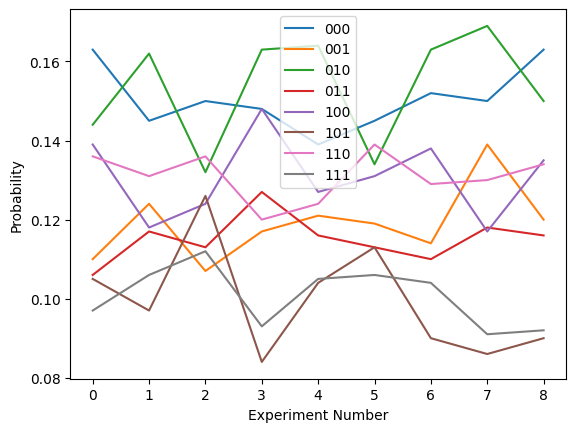

In [34]:
plt.plot(y)
plt.xlabel("Experiment Number")
plt.ylabel("Probability")
plt.legend(["000", "001", "010", "011", "100", "101", "110", "111"])
#plt.yscale("log")
plt.show()